 # Прогнозирование оттока клиентов в сети отелей «Как в гостях»

## Описание к проекту


Заказчик этого исследования — сеть отелей «Как в гостях».

Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.

Чтобы решить эту проблему, нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.


## 1. Чтение данных

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

pd.set_option('display.max_columns', None)

In [2]:
hotel = pd.read_csv('/code/data/Hotel/hotel_train.csv')
display(hotel.head())
hotel.info()
print((hotel['arrival_date_year'].unique()))

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

*Вывод:*
    
Данные представлены за 2015 - 2016 годы. Пропущенных значений нет.

In [3]:
hotel_test = pd.read_csv('/code/data/Hotel/hotel_test.csv')
display(hotel_test.head())
hotel_test.info()
print((hotel_test['arrival_date_year'].unique())) 

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

*Вывод:*

Данные представлены за 2017 год. Пропущенных значений нет. Типы данных по колонкам совпадают.

## 2. Предобработка и исследовательский анализ данных

In [4]:
for column in hotel:
    print(hotel[column].unique())
    print(hotel_test[column].unique())
    print(f'Уникальных значений *hotel* по "{column}" {len(hotel[column].unique())}.')
    print(f'Уникальных значений *hotel_test* по "{column}" {len(hotel_test[column].unique())}.')
    print('____________________________________________________')
    
print('Явных дубликатов в таблице *hotel*:', hotel.duplicated().sum())
print('Явных дубликатов в таблице *hotel_test*: ', hotel_test.duplicated().sum())


[    0     1     2 ... 84094 84117 84121]
[ 6086  6087  6088 ... 97901 97902 97903]
Уникальных значений *hotel* по "id" 65229.
Уникальных значений *hotel_test* по "id" 32412.
____________________________________________________
[0 1]
[1 0]
Уникальных значений *hotel* по "is_canceled" 2.
Уникальных значений *hotel_test* по "is_canceled" 2.
____________________________________________________
[  7.  14.   0.   9.  85.  75.  23.  18.  68.  37.  72.  48.  77.  99.
  40.  15.  36.  70.  45.  16. 107.  47.  96. 113.  50.   3.   1.  10.
   5.  17.  93.  71.  63.  62. 101.   2.  81.  12. 109. 102.   4.  92.
  95.  86.  78.  29.  30.  51.  33.   8. 100.  80.  97.  64.  90.  27.
  82.  94. 115. 111.  98.  66. 104.  65.  55.  21.  88.  43.  54. 280.
  24. 103. 249.  13.  79.  35.  31.  34.  44. 304. 117.  84. 110.  59.
 116.  91.  42.  60. 321.  32.  56.  41.  76.  49.  73. 112.  39.  58.
  57.  19.  53.  38.   6. 108.  26. 123.  28. 118.  46.  69.  52.  89.
  61.  22.  67. 105.  25.  11.  87. 29

**lead_time**

(494, 25)
count    65229.000000
mean        96.337917
std         96.127545
min          0.000000
25%         17.000000
50%         64.000000
75%        151.000000
max        374.000000
Name: lead_time, dtype: float64


1    402
0     92
Name: is_canceled, dtype: int64

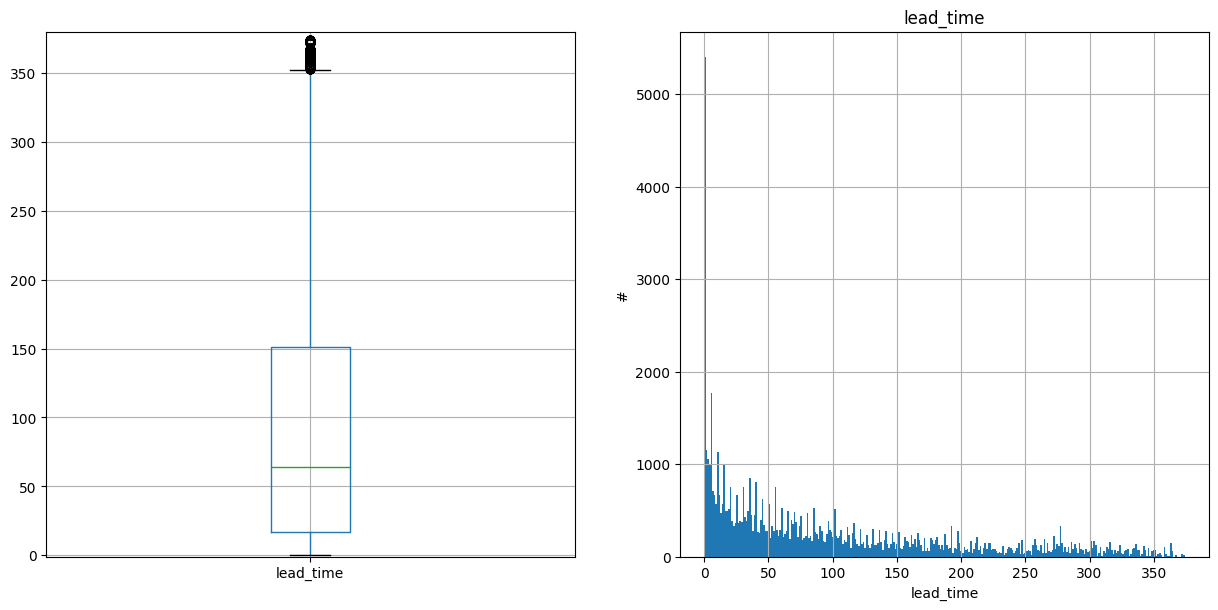

In [5]:
plt.figure(figsize=(15,15))
plt.subplot(2, 2, 1)
hotel.filter(items=['lead_time']).boxplot()
plt.ylim(-1, 380)
plt.subplot(2,2,2)
plt.ylabel("#")
plt.xlabel("lead_time")
plt.title("lead_time")
hotel['lead_time'].hist(range=(0,374), bins=300)

print(hotel[hotel['lead_time'] > 351].shape)

print(hotel['lead_time'].describe())

lid_time_anom = hotel.query('lead_time > 351')
lid_time_anom['is_canceled'].value_counts()

По данному столбцу выявлено 494 строки с аномальными значениями, но удалять их не нужно, так как среди всех этих значений количество отказавшихся от брони составляет 402, а это  82%. 

**previous_cancellations**

(5638, 25)
1    5396
0     242
Name: is_canceled, dtype: int64


count    65229.000000
mean         0.128915
std          0.965326
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         26.000000
Name: previous_cancellations, dtype: float64

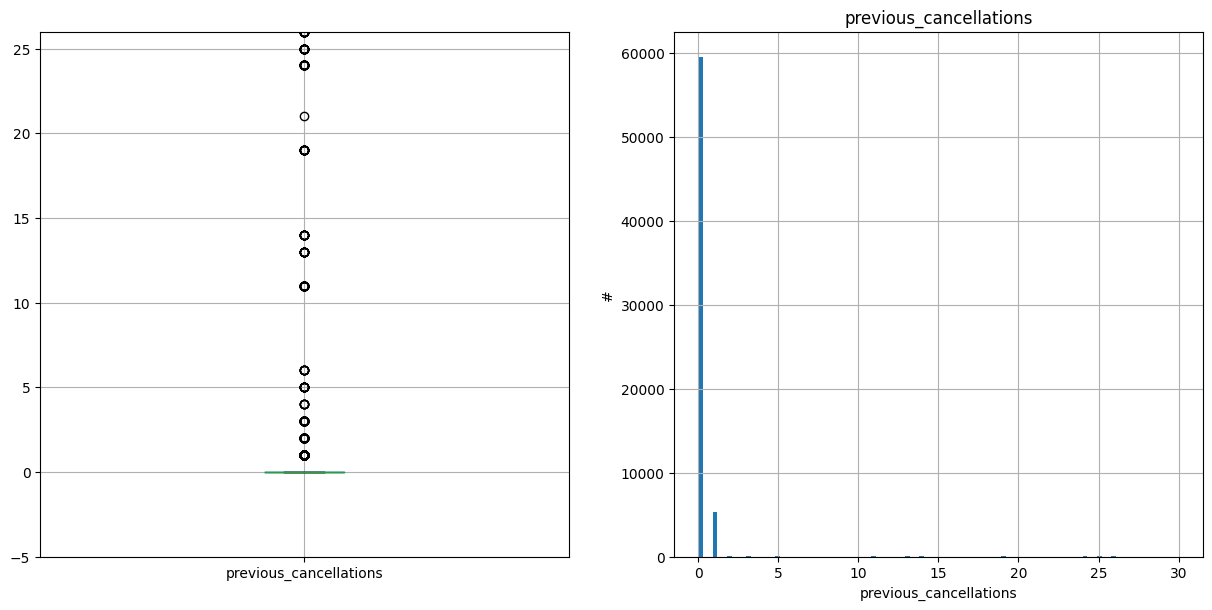

In [6]:
plt.figure(figsize=(15,15))
plt.subplot(2, 2, 1)
hotel.filter(items=['previous_cancellations']).boxplot()
plt.ylim(-5,26)
plt.subplot(2,2,2)
plt.ylabel("#")
plt.xlabel("previous_cancellations")
plt.title("previous_cancellations")
hotel['previous_cancellations'].hist(range=(0,30), bins=100)

print(hotel[hotel['previous_cancellations'] > 0].shape)
previous_cancellations_anom = hotel.query('previous_cancellations > 0')
print(previous_cancellations_anom['is_canceled'].value_counts())

hotel['previous_cancellations'].describe()

В аномали попали все значения, отличные от нуля. Подавляющее большинство данных по отказавшимся от брони 5396 из 5638. Ящик с усами «схлопнулся» на графике в одно значение из-за очень сильно доминирующей группы с нулевым значением этого признака. Такая статистика может означать,что либо клиенты редко отменяли бронь, либо ранее не бронировали номер, либо являются новыми клиентами. Удальть их не нужно.

**previous_bookings_not_canceled**

0    1445
1      98
Name: is_canceled, dtype: int64


count    65229.000000
mean         0.107713
std          1.326638
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         58.000000
Name: previous_bookings_not_canceled, dtype: float64

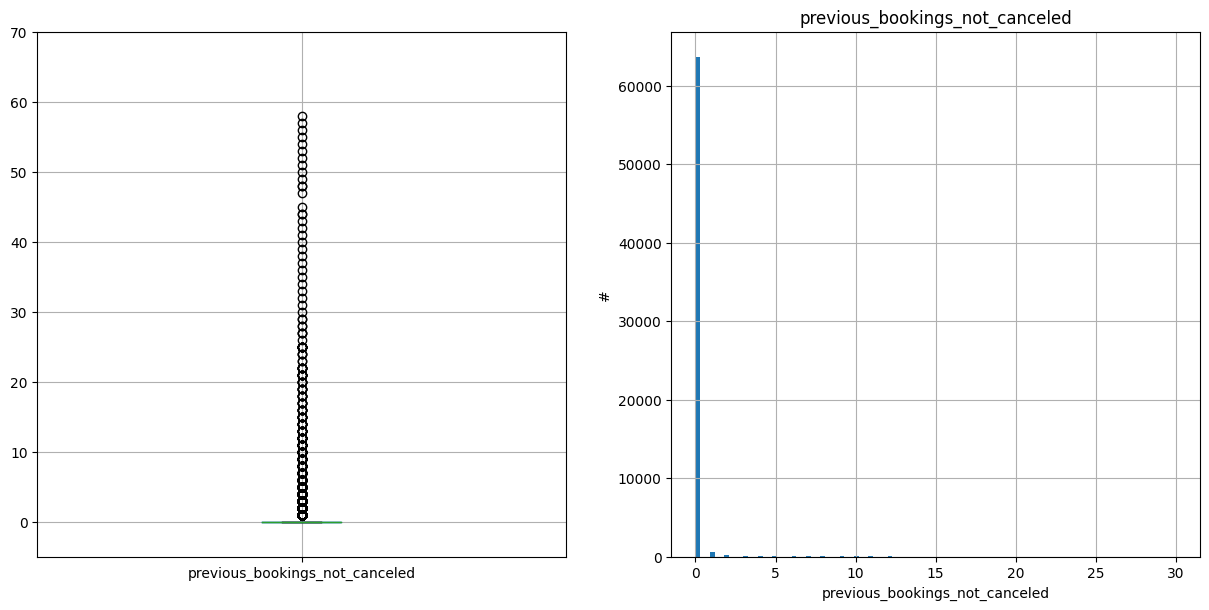

In [7]:
plt.figure(figsize=(15,15))
plt.subplot(2, 2, 1)
hotel.filter(items=['previous_bookings_not_canceled']).boxplot()
plt.ylim(-5,70)
plt.subplot(2,2,2)
plt.ylabel("#")
plt.xlabel("previous_bookings_not_canceled")
plt.title("previous_bookings_not_canceled")
hotel['previous_bookings_not_canceled'].hist(range=(0,30), bins=100)


previous_bookings_not_canceled_anom = hotel.query('previous_bookings_not_canceled > 0')
print(previous_bookings_not_canceled_anom['is_canceled'].value_counts())

hotel['previous_bookings_not_canceled'].describe()


Ситуация, схожая с предыдущим столбцом. В аномалиях все значения больше 0, однако сильно больше неотказавшихся от брони.

**days_in_waiting_list**

(62005, 25)
1    2119
0    1105
Name: is_canceled, dtype: int64


count    65229.000000
mean         3.334422
std         18.239606
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        259.000000
Name: days_in_waiting_list, dtype: float64

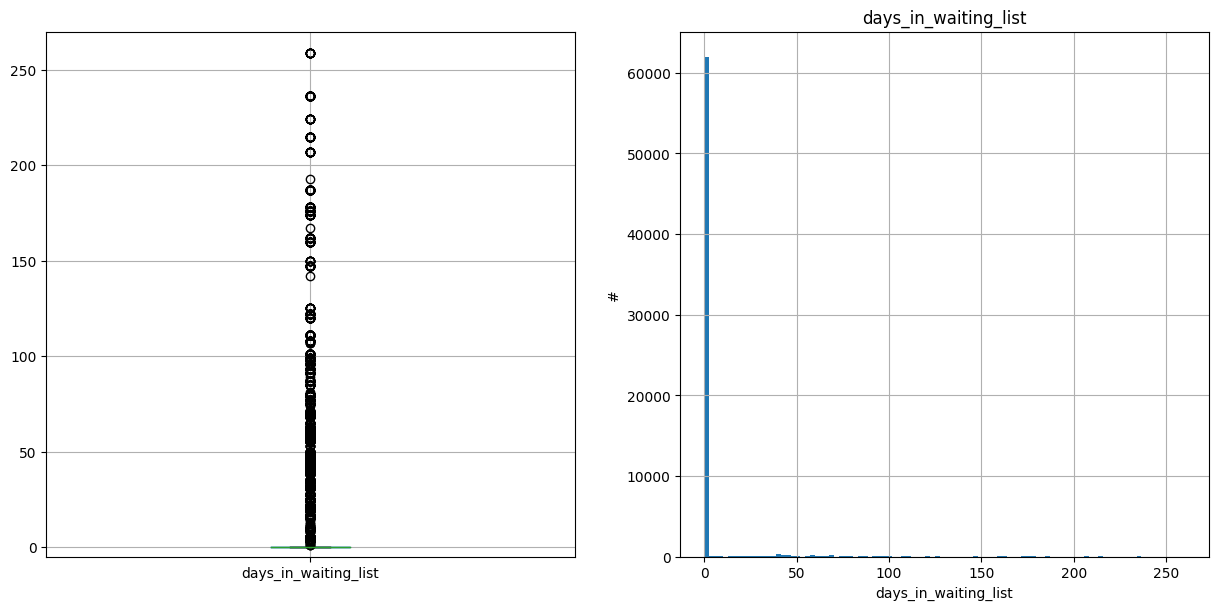

In [8]:
plt.figure(figsize=(15,15))
plt.subplot(2, 2, 1)
hotel.filter(items=['days_in_waiting_list']).boxplot()
plt.ylim(-5,270)
plt.subplot(2,2,2)
plt.ylabel("#")
plt.xlabel("days_in_waiting_list")
plt.title("days_in_waiting_list")
hotel['days_in_waiting_list'].hist(range=(0,260), bins=100)

print(hotel[hotel['days_in_waiting_list'] == 0].shape)
days_in_waiting_list_anom = hotel.query('days_in_waiting_list > 0')
print(days_in_waiting_list_anom['is_canceled'].value_counts())
hotel['days_in_waiting_list'].describe()

Здесь то же самое.



***Все выше описанные аномалии удалять не буду, т.к. считаю эти значения статистически важными для обучения модели. Это история клиентов, возможно, эти данные начали собирать совсем недавно.***

**Вывод:** 

Данные представлены в двух выборках: тренировочная - **"hotel"** и тестовая - **"hotel_test"**, содержащих 65229 и 32412 строк соответственно.

В **"hotel"** предоставлены данные за период 2015, 2016 годы.Пропущенные значения и явные дубликаты отстутсвуют.

В **"hotel_test"**  за 2017 год. Пропущенных значений нет.Явных дубликатов нет.


В обеих таблицах содержатся одинаковые столбцы:

-**id** — номер записи — порядковый тип данных с уникальными значениями- удалить из обеих выборок;

-**is_canceled** — отмена заказа — целевой признак с бинарной классификацией, уникальных значений по 2,где **"1"** - клиент отказался от брони;

-**lead_time** — количество дней между датой бронирования и датой прибытия, соотношение уникальных значений в **"hotel"** -369 в **"hotel_test"** - 368;

-**arrival_date_year** — год заезда;в **"hotel"** -2015 и 2016, в **"hotel_test"** - 2017;

-**arrival_date_month** — месяц заезда - категориальный признак, уникальных значений в **"hotel"** - 12 в **"hotel_test"** - 8 (неполный год)

-**arrival_date_week_number** — неделя заезда, соотношение уникальных значений 53/35;

-**arrival_date_day_of_month** — день заезда;

-   **stays_in_weekend_nights** — количество ночей в выходные дни, соотношение уникальных значений 5/5;

-   **stays_in_week_nights** — количество ночей в будние дни, соотношение уникальных значений 7/7;

-**adults** — количество взрослых постояльцев;

**children** — количество детей от 3 до 14 лет;

-**babies** — количество младенцев, соотношение уникальных значений 5/3 (неадекватное кол-во младенцев (9 и 10) в **"hotel"**);

-**meal** — опции заказа:  - категориальный признак, содержит пробелы; 

        •SC — нет дополнительных опций;

        •BB — включён завтрак;

        •HB — включён завтрак и обед;

        •FB — включён завтрак, обед и ужин.

-**country** — гражданство постояльца - категориальный признак, уникальных значений в **"hotel"** - 155 в **"hotel_test"** - 143;

-**distribution_channel** — канал дистрибуции заказа - категориальный признак, по 4 канала в каждой таблице;

-**is_repeated_guest** — признак того, что гость бронирует номер второй раз, бинарный, где "1" - повторное бронирование;

-**previous_cancellations** — количество отменённых заказов у клиента;

-**previous_bookings_not_canceled** — количество подтверждённых заказов у клиента, 58/46; 

-**reserved_room_type** — тип забронированной комнаты  - категориальный признак, уникальных значений в **"hotel"**  и **"hotel_test"** по 7, присутствуют пробелы.

-**booking_changes** — количество изменений параметров заказа, 16/15; 

-**days_in_waiting_list** — сколько дней заказ ожидал подтверждения, 97/75; 

-**customer_type** — тип заказчика: - категориальный признак, кол-во уникальных значений в **"hotel"**  и **"hotel_test"** по 4;

        •Contract — договор с юридическим лицом;

        •Group — групповой заезд;

        •Transient — не связано с договором или групповым заездом;

        •Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.

-**required_car_parking_spaces** — необходимость места для автомобиля,соотношение уникальных значений 4/5 (неадекватное кол-во (8 ) паркомест в **"hotel_test"**), вероятная опечатка)

-**total_of_special_requests** — количество специальных отметок, в обоих датасетах по 6 кодов отметок от 0 до 5, расшифровки кодов заказчиком не представлены;

-**total_nights** — общее количество ночей ( 1-10 ночей), кол-во уникальных значений в таблицах одинаково.



В таблице ниже выведены на печать строки содержащие аномальные значения которые были исправлены- это 8 паркомест, таких строки 2 из 65 229, и кол-во младенцев со значениями больше 2-х, таких тоже 2строки. Суммарная  доля этих аномалий 4/65 229 
    

    

In [9]:
# Замена количества младенцев
display(hotel.loc[hotel['babies'] > 2])
hotel = hotel.replace({'babies':{10:1, 9:0}})
display(hotel['babies'].value_counts().head())
print('___________________________________________________________________________')

# Замена количества парковочных мест d hotel_test
display(hotel_test.loc[hotel_test['required_car_parking_spaces'] == 8])
hotel = hotel.replace({'required_car_parking_spaces':{8:3}})
display(hotel['required_car_parking_spaces'].value_counts().head())
print('___________________________________________________________________________')

# Удаление пробелов в строковых значениях  
hotel['meal'] = hotel['meal'].str.strip()
print('Уникальных значений *hotel* по "meal" - ' , (hotel['meal'].unique()))

hotel_test['meal'] = hotel_test['meal'].str.strip()
print('Уникальных значений *hotel_test* по "meal" - ' , (hotel_test['meal'].unique()))

hotel['reserved_room_type'] = hotel['reserved_room_type'].str.strip()
hotel_test['reserved_room_type'] = hotel_test['reserved_room_type'].str.strip()

print(f'Уникальных значений *hotel* по "reserved_room_type" - ', (hotel['reserved_room_type'].unique()))
print(f'Уникальных значений *hotel_test* по "reserved_room_type" - ', (hotel_test['reserved_room_type'].unique()))

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
22995,30935,0,37.0,2016,January,3,12,0,2,2.0,0.0,10.0,BB,PRT,TA/TO,0,0,0,D,1,0,Transient,0,1,2
41528,59925,0,11.0,2015,October,42,11,2,1,1.0,0.0,9.0,BB,GBR,Corporate,0,0,0,A,1,0,Transient-Party,0,0,3


0.0    64778
1.0      448
2.0        3
Name: babies, dtype: int64

___________________________________________________________________________


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
2549,17717,0,26.0,2017,March,11,14,0,5,2.0,0.0,0.0,HB,AUT,Corporate,1,0,2,E,1,0,Transient-Party,8,1,5
2550,17718,0,138.0,2017,March,12,19,2,2,2.0,0.0,0.0,HB,AUT,Corporate,1,0,2,E,1,122,Transient-Party,8,0,4


0    61547
1     3670
2       11
3        1
Name: required_car_parking_spaces, dtype: int64

___________________________________________________________________________
Уникальных значений *hotel* по "meal" -  ['BB' 'FB' 'HB' 'SC']
Уникальных значений *hotel_test* по "meal" -  ['BB' 'HB' 'SC' 'FB']
Уникальных значений *hotel* по "reserved_room_type" -  ['A' 'C' 'D' 'E' 'G' 'F' 'B']
Уникальных значений *hotel_test* по "reserved_room_type" -  ['A' 'E' 'G' 'D' 'F' 'C' 'B']



  **Матрица диаграмм рассеяния:**


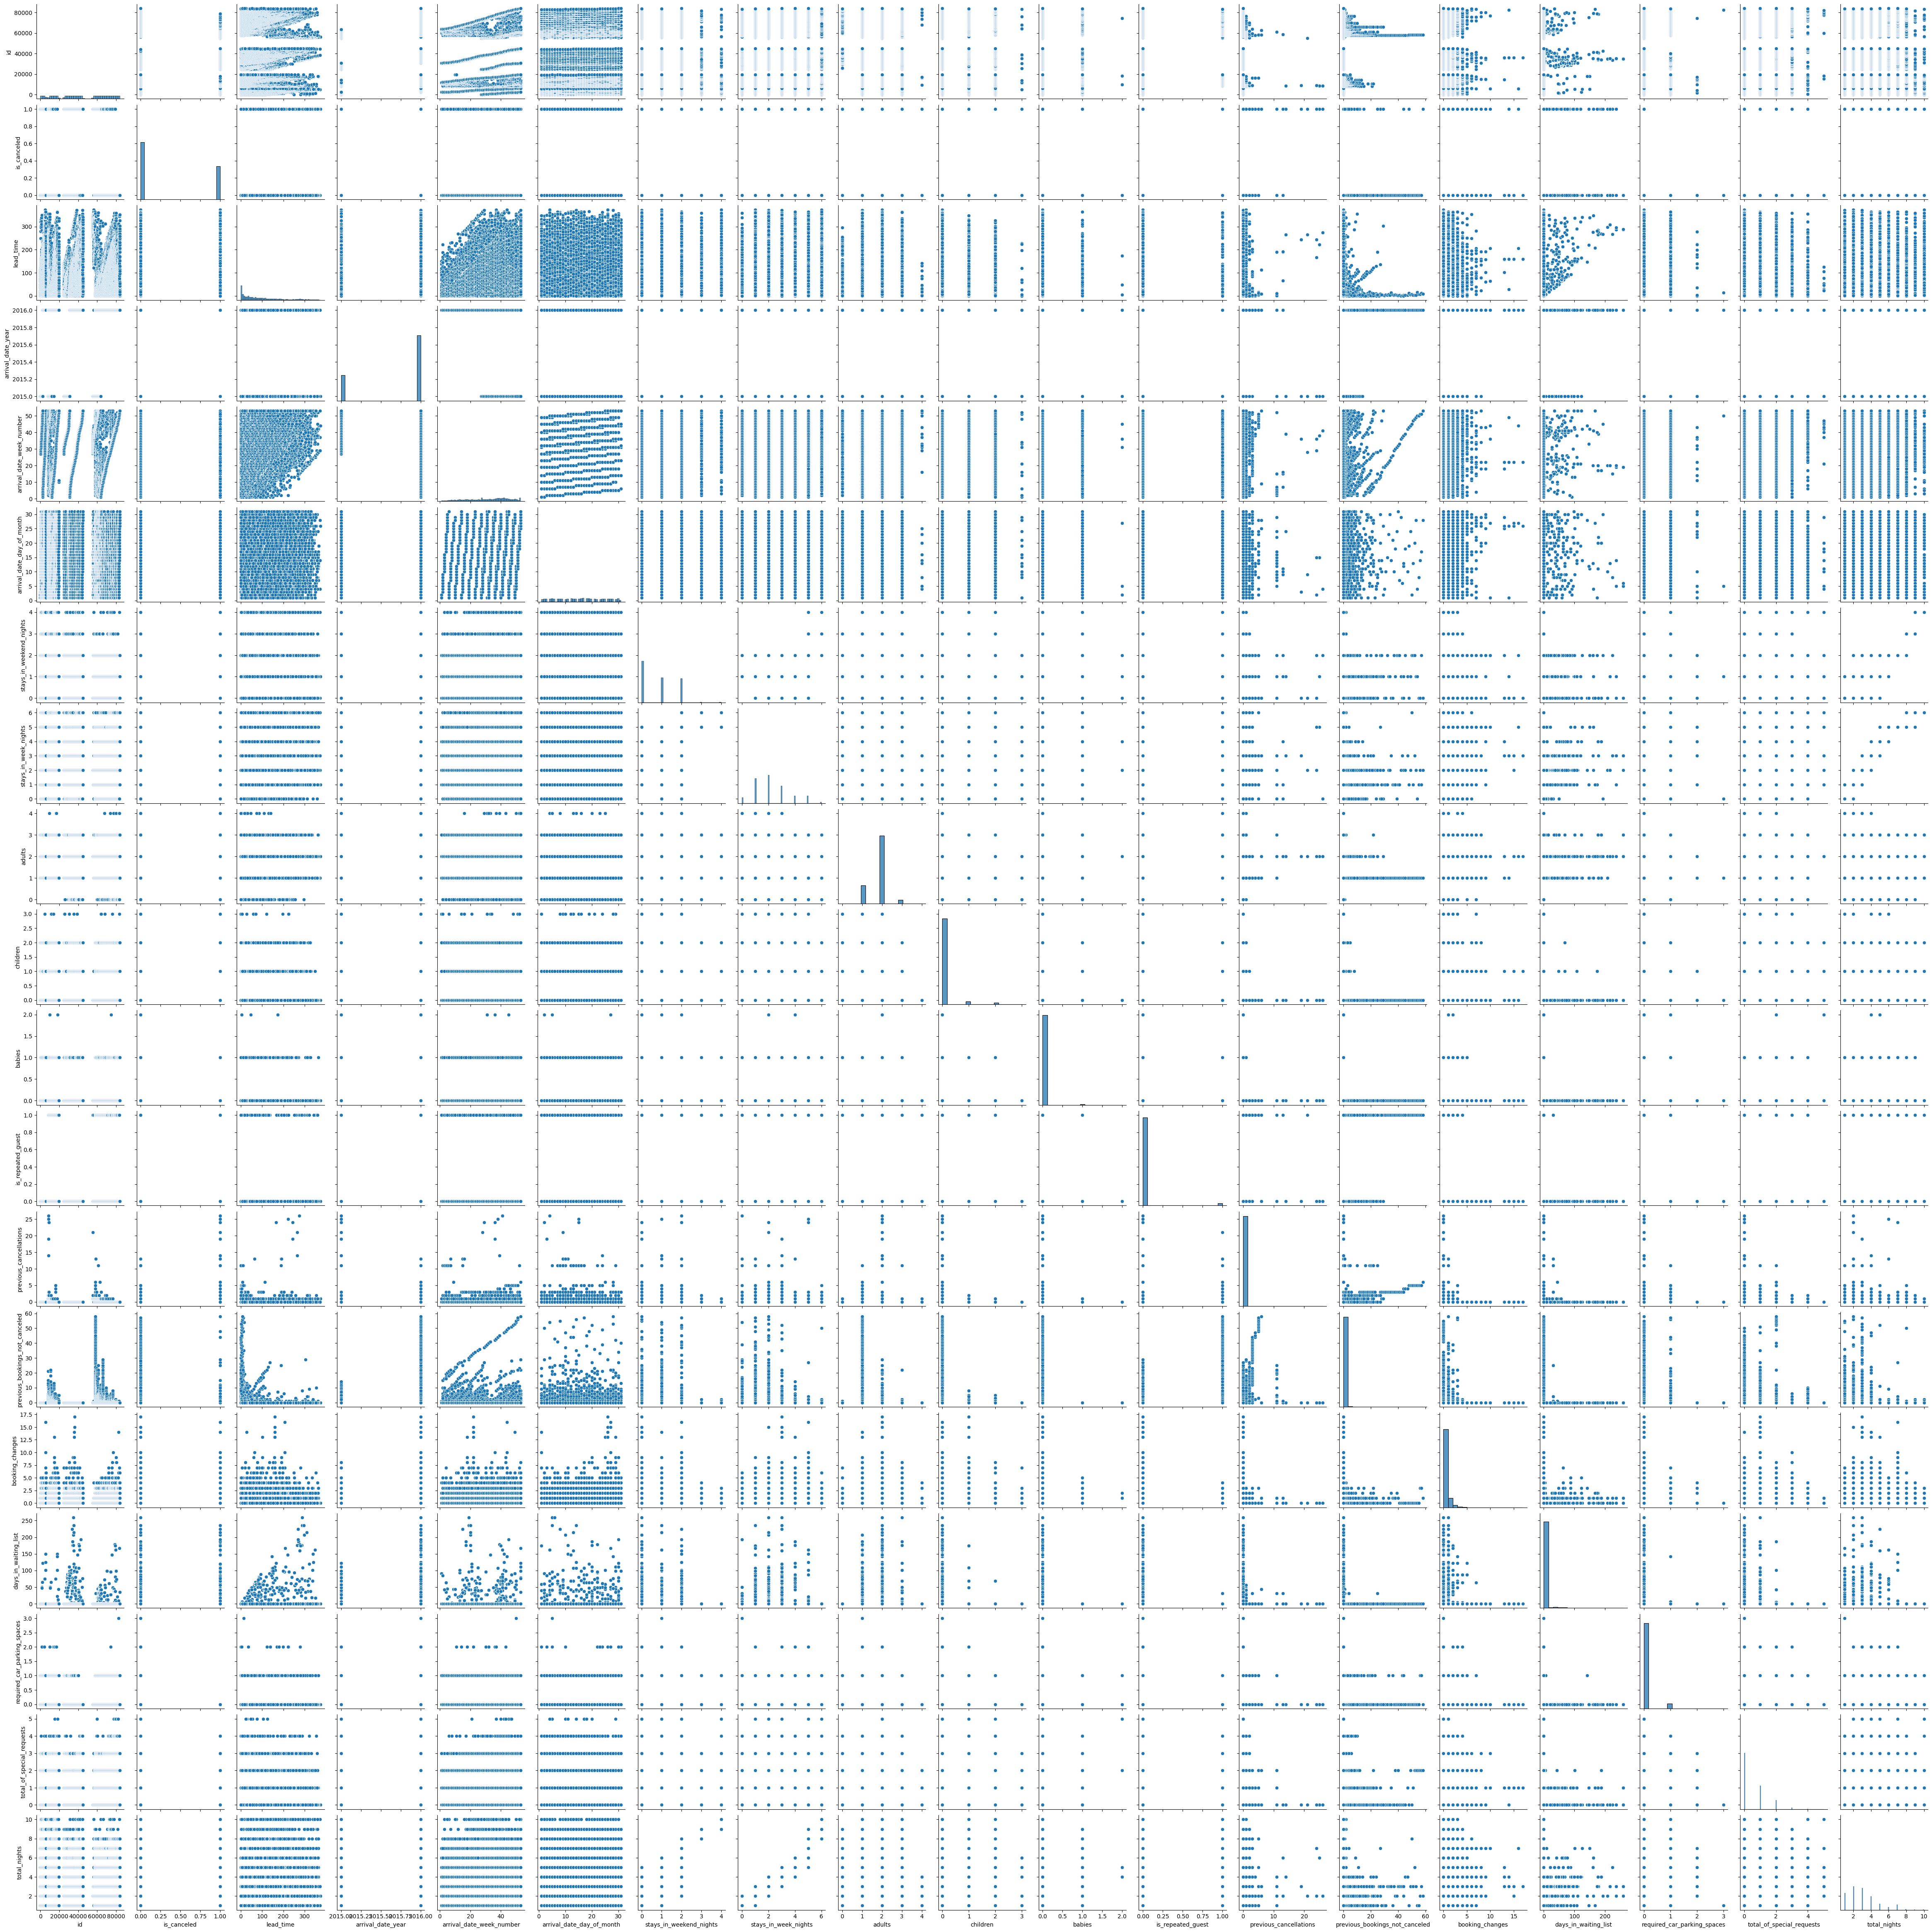

In [10]:
sns.pairplot(hotel, palette='Set3', markers=["s", "D"])

        
Признаков многовато. По текущему графику можно заметить, что диаграммы не для всех пар достаточно информативны.


**Тепловая матрица:**

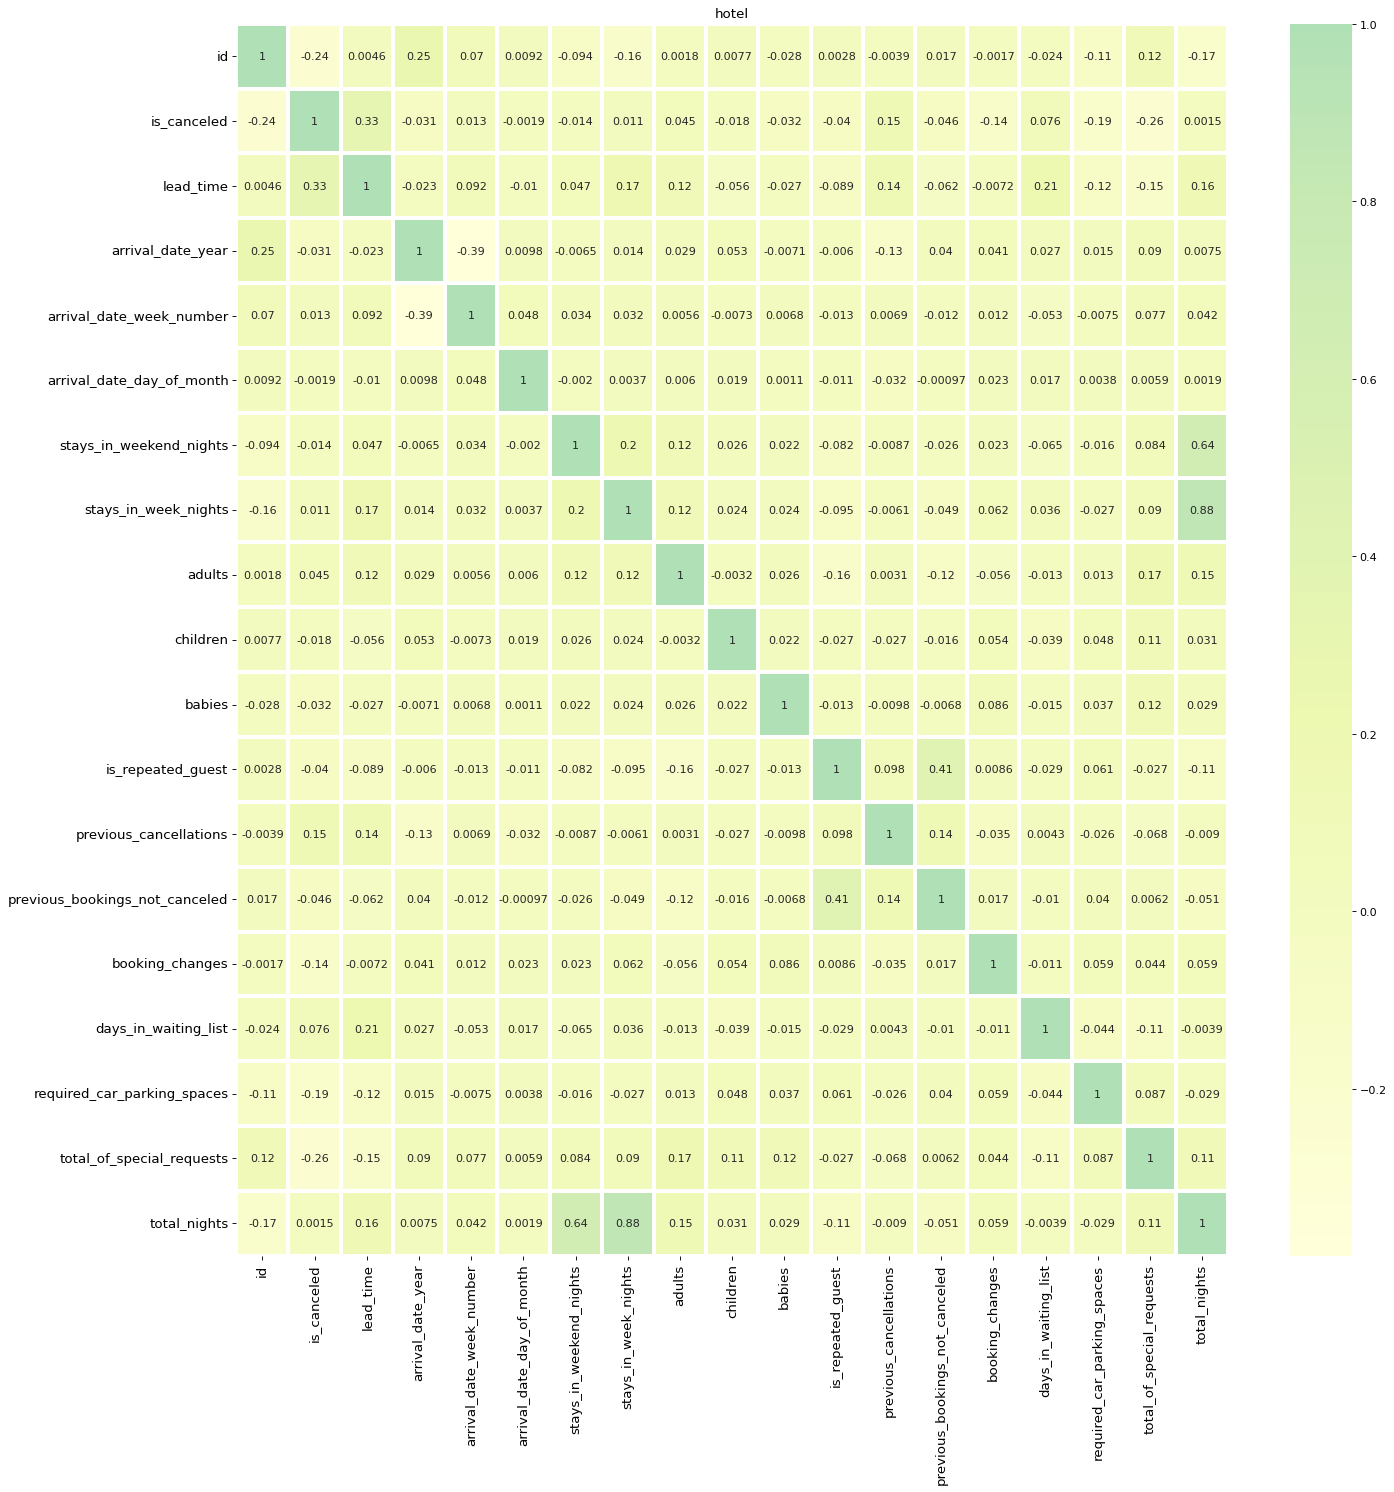

In [11]:
plt.figure(figsize=(20.0,20.0), dpi= 80)
sns.heatmap(
    hotel.corr(),
    xticklabels= hotel.corr().columns,
    yticklabels=hotel.corr().columns,
    cmap='YlGnBu',
    center=2,
    annot=True,
    linewidths=2,
    linecolor='white'
)


plt.title('hotel', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

 Наблюдается мультиколлинеарность между обучающими признаками: признак "total_nights" сильно коррелирует с:
    
    "stays_in_weekend_nights" (corr = 0.64)
    
    "stays_in_week_nights" (corr = 0.88)
    
Удалим данные признаки  и признак "id" из обеих выборок:

In [12]:
hotel = hotel.drop(['id', 'stays_in_weekend_nights', 'stays_in_week_nights'], axis = 1)
hotel_test = hotel_test.drop(['id', 'stays_in_weekend_nights', 'stays_in_week_nights'], axis = 1)

display(hotel.head())
display(hotel_test.head())

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,7.0,2015,July,27,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,0,14.0,2015,July,27,1,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,0,0.0,2015,July,27,1,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,0,9.0,2015,July,27,1,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,1,85.0,2015,July,27,1,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,1,74.0,2017,January,1,1,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,1,62.0,2017,January,1,1,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
2,1,62.0,2017,January,1,1,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
3,1,71.0,2017,January,1,1,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
4,1,172.0,2017,January,1,1,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7


## 3. Формулировка ML-задачи на основе бизнес-задачи

Сеть отелей «Как в гостях», с целью привлечения клиентов, добавила на свой сайт возможность забронировать номер без предоплаты. Однако, если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.

**ML-задача:** - Разработать модель, предсказывающую отказ от брони.

разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.
Бизнес-метрика и другие данные

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца.
В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.

Стоимость номеров отеля (**reserved_room_type**):

•		категория A: за ночь — 1 000, разовое обслуживание — 400;

•		категория B: за ночь — 800, разовое обслуживание — 350;

•		категория C: за ночь — 600, разовое обслуживание — 350;

•		категория D: за ночь — 550, разовое обслуживание — 150;

•		категория E: за ночь — 500, разовое обслуживание — 150;

•		категория F: за ночь — 450, разовое обслуживание — 150;

•		категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты(**arrival_date_month**)  : весной и осенью цены повышаются на 20%, летом — на 40%.

На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за год. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.


**Расчет прибыли сети отелей до внедрения системы прогрнозирования.**

Для расчетов используем копию тестовой выборки со столбцами, необходимыми для расчетов. 

    1.Таблицу сохраним в переменной **hotel_profit**. Необходимы следующие колонки: 
   is_canceled — отмена заказа;
   arrival_date_year — год заезда;
   arrival_date_month — месяц заезда;
   reserved_room_type - тип номера
   arrival_date_day_of_month — день заезда;
   total_nights - общее количество ночей.
    
    2.Создание словарей для обеспечения соответствия сезонных коэффициентов (зима-1, весна и осень- 1.2, лето-1.4)  и номеров месяцам года (1 - 12), цен и стоимости разового обслуживания типам номеров.  


In [13]:
# создание копии тестовой выборки для расчета бизнесметрик
hotel_profit = hotel_test[['is_canceled', 'arrival_date_year', 'arrival_date_month', 'reserved_room_type', 'total_nights']]

# создание словарей для номера месяца и сезонных коэффициентов:
key_coeff = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
month_num = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
val_coeff = [1, 1, 1.2, 1.2, 1.2, 1.4, 1.4, 1.4, 1.2, 1.2, 1.2, 1]
dict_month = dict(zip(key_coeff, month_num))
dict_coeff = dict(zip(key_coeff, val_coeff))
print(dict_month, dict_coeff)
print('-------------------------------------------------')

# создание словарей для цены номера за ночь и стоимости разового обслуживания по типам номеров:
roome_type = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
val_price = [1000, 800, 600, 550, 500, 450, 350]
val_clean = [400, 350, 350, 150, 150, 150, 150]
price_night = dict(zip(roome_type, val_price))
price_clean = dict(zip(roome_type, val_clean))
print(price_night)
print('-------------------------------------------------')
print(price_clean)

{'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12} {'January': 1, 'February': 1, 'March': 1.2, 'April': 1.2, 'May': 1.2, 'June': 1.4, 'July': 1.4, 'August': 1.4, 'September': 1.2, 'October': 1.2, 'November': 1.2, 'December': 1}
-------------------------------------------------
{'A': 1000, 'B': 800, 'C': 600, 'D': 550, 'E': 500, 'F': 450, 'G': 350}
-------------------------------------------------
{'A': 400, 'B': 350, 'C': 350, 'D': 150, 'E': 150, 'F': 150, 'G': 150}



**Добавление колонок в 'hotel_profit' для расчета прибыли отеля**

Колонка 'month' добавлена с целью упорядочения доходов по месяцам.

In [14]:
hotel_profit['month'] = hotel_profit.apply(lambda row: dict_month[row.arrival_date_month], axis=1)
hotel_profit['night_price'] = hotel_profit.apply(lambda row: price_night[row.reserved_room_type], axis=1)
hotel_profit['price_clean'] = hotel_profit.apply(lambda row: price_clean[row.reserved_room_type], axis=1)
hotel_profit['coeff_season'] = hotel_profit.apply(lambda row: dict_coeff[row.arrival_date_month], axis=1)
display(hotel_profit.head(), hotel_profit.tail())

,is_canceled,arrival_date_year,arrival_date_month,reserved_room_type,total_nights,month,night_price,price_clean,coeff_season
0,1,2017,January,A,1,1,1000,400,1.0
1,1,2017,January,A,4,1,1000,400,1.0
2,1,2017,January,A,4,1,1000,400,1.0
3,1,2017,January,A,4,1,1000,400,1.0
4,1,2017,January,A,7,1,1000,400,1.0


,is_canceled,arrival_date_year,arrival_date_month,reserved_room_type,total_nights,month,night_price,price_clean,coeff_season
32407,0,2017,August,A,6,8,1000,400,1.4
32408,0,2017,August,A,7,8,1000,400,1.4
32409,0,2017,August,A,7,8,1000,400,1.4
32410,0,2017,August,D,7,8,550,150,1.4
32411,0,2017,August,A,7,8,1000,400,1.4


**Расчет выручки за все время пребывания:**

In [15]:
# Расчет выручки за все время пребывания:
def income_night(is_canceled, night_price, coeff_season, total_nights):    
    if is_canceled == 0 :
        return night_price * coeff_season * total_nights
    else:
        return 0
    
    
hotel_profit['income_night'] = hotel_profit.apply(lambda x:income_night(x['is_canceled'], x['night_price'], x['coeff_season'], x['total_nights']), axis=1)


display(hotel_profit.query('is_canceled == 0').head(2))
display(hotel_profit.query('is_canceled == 1').tail(2))

,is_canceled,arrival_date_year,arrival_date_month,reserved_room_type,total_nights,month,night_price,price_clean,coeff_season,income_night
95,0,2017,January,A,1,1,1000,400,1.0,1000.0
299,0,2017,February,A,4,2,1000,400,1.0,4000.0


,is_canceled,arrival_date_year,arrival_date_month,reserved_room_type,total_nights,month,night_price,price_clean,coeff_season,income_night
26085,1,2017,July,A,1,7,1000,400,1.4,0.0
30673,1,2017,August,A,2,8,1000,400,1.4,0.0


**Расчет количества уборок за период пребывания без учета разового обслуживания при подготовке номера:**

In [16]:
# расчет количества уборок за период пребывания без учета разового обслуживания при подготовке номера:
def clean_calc(n):
    if n == 2:
        return 0

    cnt = 1
    pay = 0

    for i in range(1, n):
        if cnt == 2:
            pay += 1
            cnt = 1
        else:
            cnt += 1
    return pay


hotel_profit['clean_for_period'] = hotel_profit.apply(lambda row: clean_calc(row.total_nights), axis=1)

def profit(is_canceled, income_night, price_clean, clean_for_period):    
    if is_canceled == 1 :
        return income_night - price_clean
    else:
        return income_night - (price_clean + (price_clean * clean_for_period))
    
hotel_profit['profit'] = hotel_profit.apply(lambda x:profit(x['is_canceled'], x['income_night'], x['price_clean'], x['clean_for_period']), axis=1)
display(hotel_profit.query('is_canceled == 0').head())
display(hotel_profit.query('is_canceled == 1').head())

,is_canceled,arrival_date_year,arrival_date_month,reserved_room_type,total_nights,month,night_price,price_clean,coeff_season,income_night,clean_for_period,profit
95,0,2017,January,A,1,1,1000,400,1.0,1000.0,0,600.0
299,0,2017,February,A,4,2,1000,400,1.0,4000.0,1,3200.0
2041,0,2017,August,A,1,8,1000,400,1.4,1400.0,0,1000.0
2125,0,2017,February,A,3,2,1000,400,1.0,3000.0,1,2200.0
2126,0,2017,January,A,1,1,1000,400,1.0,1000.0,0,600.0


,is_canceled,arrival_date_year,arrival_date_month,reserved_room_type,total_nights,month,night_price,price_clean,coeff_season,income_night,clean_for_period,profit
0,1,2017,January,A,1,1,1000,400,1.0,0.0,0,-400.0
1,1,2017,January,A,4,1,1000,400,1.0,0.0,1,-400.0
2,1,2017,January,A,4,1,1000,400,1.0,0.0,1,-400.0
3,1,2017,January,A,4,1,1000,400,1.0,0.0,1,-400.0
4,1,2017,January,A,7,1,1000,400,1.0,0.0,3,-400.0


## 4. Разработка модели ML

**Целевой признак  — 'is_canceled'**.

Данный  целевой признак содержит всего две категории, следовательно речь идёт о бинарной (двоичной) классификации. К данной задаче классификации подойдут следующие модели: логистическая регрессия, дерево решений, случайный лес.

Проведем проверку соотношения классов.

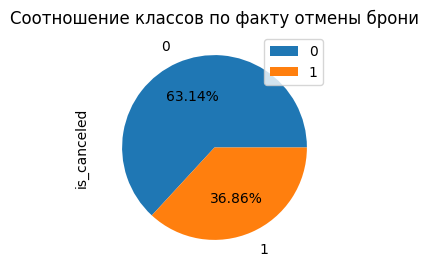

In [17]:
hotel['is_canceled'].value_counts().plot.pie(legend=True, labeldistance=1.2, autopct='%1.2f%%', figsize=(3,3), 
                title='Соотношение классов по факту отмены брони'
)
plt.show()

**Вывод**

Дисбаланс классов 63:37. Почти 37 % клиентов отменили заказ против 63% заселившихся в номера. Проведение балансировки классов укажем в гиперпараматрах моделей.

### Преобразование категориальных признаков в количественные

Так как в обучающей выборке количество уникальных категориальных значений превосходит количество в тестовой выборке, для  преобразования категориальных признаков в численные, и количество колонок с наименованиями идентичны, можно добавить строки тестового датасета к тренировочному. Для этого достаточно метода **append()** , без сортировки. 
    
После преобразования полученного фрейма, разделим таблицы обратно- на обучающую и тестовую.

In [18]:
# добавление строк теста к трейну
for_ohe = hotel.append(hotel_test, sort=False)
display(for_ohe.shape)

# проверка на пропуски
display(for_ohe.isna().sum())

# преобразование с помощью One-Hot Encoding
df_ohe = pd.get_dummies(for_ohe, drop_first=True)
display(df_ohe.shape)

# разделение на тестовую и тренировочную
ohe_hotel = df_ohe[0:65229]
ohe_hotel_test = df_ohe[65229:]
display(ohe_hotel.head(3), ohe_hotel.shape)
display(ohe_hotel_test.head(3), ohe_hotel_test.shape)
# проверка по году
print('Уникальных значений *ohe_hotel* по "arrival_date_year" - ' , (ohe_hotel['arrival_date_year'].unique()))
print('Уникальных значений *ohe_hotel_test* по "arrival_date_year" - ' , (ohe_hotel_test['arrival_date_year'].unique()))

(97641, 22)

is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64

(97641, 215)

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_FB,meal_HB,meal_SC,country_AGO,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_ASM,country_ATA,country_ATF,country_AUS,country_AUT,country_AZE,country_BDI,country_BEL,country_BEN,country_BFA,country_BGD,country_BGR,country_BHR,country_BHS,country_BIH,country_BLR,country_BOL,country_BRA,country_BRB,country_BWA,country_CAF,country_CHE,country_CHL,country_CHN,country_CIV,country_CMR,country_CN,country_COL,country_CPV,country_CRI,country_CUB,country_CYM,country_CYP,country_CZE,country_DEU,country_DMA,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_ETH,country_FIN,country_FJI,country_FRA,country_FRO,country_GAB,country_GBR,country_GEO,country_GGY,country_GHA,country_GIB,country_GLP,country_GNB,country_GRC,country_GTM,country_GUY,country_HKG,country_HND,country_HRV,country_HUN,country_IDN,country_IMN,country_IND,country_IRL,country_IRN,country_IRQ,country_ISL,country_ISR,country_ITA,country_JAM,country_JEY,country_JOR,country_JPN,country_KAZ,country_KEN,country_KHM,country_KIR,country_KNA,country_KOR,country_KWT,country_LAO,country_LBN,country_LBY,country_LCA,country_LIE,country_LKA,country_LTU,country_LUX,country_LVA,country_MAC,country_MAR,country_MCO,country_MDG,country_MDV,country_MEX,country_MKD,country_MLI,country_MLT,country_MMR,country_MNE,country_MOZ,country_MRT,country_MUS,country_MWI,country_MYS,country_MYT,country_NAM,country_NCL,country_NGA,country_NIC,country_NLD,country_NOR,country_NPL,country_NZL,country_OMN,country_PAK,country_PAN,country_PER,country_PHL,country_PLW,country_POL,country_PRI,country_PRT,country_PRY,country_PYF,country_QAT,country_ROU,country_RUS,country_RWA,country_SAU,country_SDN,country_SEN,country_SGP,country_SLE,country_SLV,country_SMR,country_SRB,country_STP,country_SUR,country_SVK,country_SVN,country_SWE,country_SYC,country_SYR,country_TGO,country_THA,country_TJK,country_TMP,country_TUN,country_TUR,country_TWN,country_TZA,country_UGA,country_UKR,country_UMI,country_URY,country_USA,country_UZB,country_VEN,country_VGB,country_VNM,country_ZAF,country_ZMB,country_ZWE,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0,7.0,2015,27,1,1.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,0,14.0,2015,27,1,2.0,0.0,0.0,0,0,0,0,0,0,1,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,0,0.0,2015,27,1,2.0,0.0,0.0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

(65229, 215)

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_FB,meal_HB,meal_SC,country_AGO,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_ASM,country_ATA,country_ATF,country_AUS,country_AUT,country_AZE,country_BDI,country_BEL,country_BEN,country_BFA,country_BGD,country_BGR,country_BHR,country_BHS,country_BIH,country_BLR,country_BOL,country_BRA,country_BRB,country_BWA,country_CAF,country_CHE,country_CHL,country_CHN,country_CIV,country_CMR,country_CN,country_COL,country_CPV,country_CRI,country_CUB,country_CYM,country_CYP,country_CZE,country_DEU,country_DMA,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_ETH,country_FIN,country_FJI,country_FRA,country_FRO,country_GAB,country_GBR,country_GEO,country_GGY,country_GHA,country_GIB,country_GLP,country_GNB,country_GRC,country_GTM,country_GUY,country_HKG,country_HND,country_HRV,country_HUN,country_IDN,country_IMN,country_IND,country_IRL,country_IRN,country_IRQ,country_ISL,country_ISR,country_ITA,country_JAM,country_JEY,country_JOR,country_JPN,country_KAZ,country_KEN,country_KHM,country_KIR,country_KNA,country_KOR,country_KWT,country_LAO,country_LBN,country_LBY,country_LCA,country_LIE,country_LKA,country_LTU,country_LUX,country_LVA,country_MAC,country_MAR,country_MCO,country_MDG,country_MDV,country_MEX,country_MKD,country_MLI,country_MLT,country_MMR,country_MNE,country_MOZ,country_MRT,country_MUS,country_MWI,country_MYS,country_MYT,country_NAM,country_NCL,country_NGA,country_NIC,country_NLD,country_NOR,country_NPL,country_NZL,country_OMN,country_PAK,country_PAN,country_PER,country_PHL,country_PLW,country_POL,country_PRI,country_PRT,country_PRY,country_PYF,country_QAT,country_ROU,country_RUS,country_RWA,country_SAU,country_SDN,country_SEN,country_SGP,country_SLE,country_SLV,country_SMR,country_SRB,country_STP,country_SUR,country_SVK,country_SVN,country_SWE,country_SYC,country_SYR,country_TGO,country_THA,country_TJK,country_TMP,country_TUN,country_TUR,country_TWN,country_TZA,country_UGA,country_UKR,country_UMI,country_URY,country_USA,country_UZB,country_VEN,country_VGB,country_VNM,country_ZAF,country_ZMB,country_ZWE,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,1,74.0,2017,1,1,2.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,1,62.0,2017,1,1,2.0,0.0,0.0,0,0,0,0,0,0,1,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,1,62.0,2017,1,1,2.0,0.0,0.0,0,0,0,0,0,0,1,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

(32412, 215)

Уникальных значений *ohe_hotel* по "arrival_date_year" -  [2015 2016]
Уникальных значений *ohe_hotel_test* по "arrival_date_year" -  [2017]


**Вывод:**

Преобразование прошло успешно, количество строк выборок соответствют исходным , годы событий соответствуют исходным данным.

### Разделение и масштабирование признаков

Разделим данные обеих выборок на целевые и обучающие:

In [19]:
def make_target_features(data, target_column='exited'):
    target = data[target_column]
    features = data.drop(target_column, axis=1)
    return target, features


target, features = make_target_features(ohe_hotel, target_column='is_canceled')
display(target.head(3), features)

target_test, features_test = make_target_features(ohe_hotel_test, target_column='is_canceled')
display(target_test.head(3), features_test)

0    0
1    0
2    0
Name: is_canceled, dtype: int64

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_FB,meal_HB,meal_SC,country_AGO,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_ASM,country_ATA,country_ATF,country_AUS,country_AUT,country_AZE,country_BDI,country_BEL,country_BEN,country_BFA,country_BGD,country_BGR,country_BHR,country_BHS,country_BIH,country_BLR,country_BOL,country_BRA,country_BRB,country_BWA,country_CAF,country_CHE,country_CHL,country_CHN,country_CIV,country_CMR,country_CN,country_COL,country_CPV,country_CRI,country_CUB,country_CYM,country_CYP,country_CZE,country_DEU,country_DMA,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_ETH,country_FIN,country_FJI,country_FRA,country_FRO,country_GAB,country_GBR,country_GEO,country_GGY,country_GHA,country_GIB,country_GLP,country_GNB,country_GRC,country_GTM,country_GUY,country_HKG,country_HND,country_HRV,country_HUN,country_IDN,country_IMN,country_IND,country_IRL,country_IRN,country_IRQ,country_ISL,country_ISR,country_ITA,country_JAM,country_JEY,country_JOR,country_JPN,country_KAZ,country_KEN,country_KHM,country_KIR,country_KNA,country_KOR,country_KWT,country_LAO,country_LBN,country_LBY,country_LCA,country_LIE,country_LKA,country_LTU,country_LUX,country_LVA,country_MAC,country_MAR,country_MCO,country_MDG,country_MDV,country_MEX,country_MKD,country_MLI,country_MLT,country_MMR,country_MNE,country_MOZ,country_MRT,country_MUS,country_MWI,country_MYS,country_MYT,country_NAM,country_NCL,country_NGA,country_NIC,country_NLD,country_NOR,country_NPL,country_NZL,country_OMN,country_PAK,country_PAN,country_PER,country_PHL,country_PLW,country_POL,country_PRI,country_PRT,country_PRY,country_PYF,country_QAT,country_ROU,country_RUS,country_RWA,country_SAU,country_SDN,country_SEN,country_SGP,country_SLE,country_SLV,country_SMR,country_SRB,country_STP,country_SUR,country_SVK,country_SVN,country_SWE,country_SYC,country_SYR,country_TGO,country_THA,country_TJK,country_TMP,country_TUN,country_TUR,country_TWN,country_TZA,country_UGA,country_UKR,country_UMI,country_URY,country_USA,country_UZB,country_VEN,country_VGB,country_VNM,country_ZAF,country_ZMB,country_ZWE,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,7.0,2015,27,1,1.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,14.0,2015,27,1,2.0,0.0,0.0,0,0,0,0,0,0,1,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,0.0,2015,27,1,2.0,0.0,0.0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

0    1
1    1
2    1
Name: is_canceled, dtype: int64

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_FB,meal_HB,meal_SC,country_AGO,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_ASM,country_ATA,country_ATF,country_AUS,country_AUT,country_AZE,country_BDI,country_BEL,country_BEN,country_BFA,country_BGD,country_BGR,country_BHR,country_BHS,country_BIH,country_BLR,country_BOL,country_BRA,country_BRB,country_BWA,country_CAF,country_CHE,country_CHL,country_CHN,country_CIV,country_CMR,country_CN,country_COL,country_CPV,country_CRI,country_CUB,country_CYM,country_CYP,country_CZE,country_DEU,country_DMA,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_ETH,country_FIN,country_FJI,country_FRA,country_FRO,country_GAB,country_GBR,country_GEO,country_GGY,country_GHA,country_GIB,country_GLP,country_GNB,country_GRC,country_GTM,country_GUY,country_HKG,country_HND,country_HRV,country_HUN,country_IDN,country_IMN,country_IND,country_IRL,country_IRN,country_IRQ,country_ISL,country_ISR,country_ITA,country_JAM,country_JEY,country_JOR,country_JPN,country_KAZ,country_KEN,country_KHM,country_KIR,country_KNA,country_KOR,country_KWT,country_LAO,country_LBN,country_LBY,country_LCA,country_LIE,country_LKA,country_LTU,country_LUX,country_LVA,country_MAC,country_MAR,country_MCO,country_MDG,country_MDV,country_MEX,country_MKD,country_MLI,country_MLT,country_MMR,country_MNE,country_MOZ,country_MRT,country_MUS,country_MWI,country_MYS,country_MYT,country_NAM,country_NCL,country_NGA,country_NIC,country_NLD,country_NOR,country_NPL,country_NZL,country_OMN,country_PAK,country_PAN,country_PER,country_PHL,country_PLW,country_POL,country_PRI,country_PRT,country_PRY,country_PYF,country_QAT,country_ROU,country_RUS,country_RWA,country_SAU,country_SDN,country_SEN,country_SGP,country_SLE,country_SLV,country_SMR,country_SRB,country_STP,country_SUR,country_SVK,country_SVN,country_SWE,country_SYC,country_SYR,country_TGO,country_THA,country_TJK,country_TMP,country_TUN,country_TUR,country_TWN,country_TZA,country_UGA,country_UKR,country_UMI,country_URY,country_USA,country_UZB,country_VEN,country_VGB,country_VNM,country_ZAF,country_ZMB,country_ZWE,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,74.0,2017,1,1,2.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,62.0,2017,1,1,2.0,0.0,0.0,0,0,0,0,0,0,1,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,62.0,2017,1,1,2.0,0.0,0.0,0,0,0,0,0,0,1,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

**Масштабирование численных признаков:**

In [20]:
# Масштабирование численных признаков методом стандартизации данных
numeric = ['lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 
           'adults', 'children', 'babies', 'is_repeated_guest',
           'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list',
           'required_car_parking_spaces', 'total_of_special_requests', 'total_nights']
scaler = StandardScaler()
scaler.fit(features[numeric]) 

features[numeric] = scaler.transform(features[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
 

display(features.head(3), features.shape)
display(features_test.head(3), features_test.shape)

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_FB,meal_HB,meal_SC,country_AGO,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_ASM,country_ATA,country_ATF,country_AUS,country_AUT,country_AZE,country_BDI,country_BEL,country_BEN,country_BFA,country_BGD,country_BGR,country_BHR,country_BHS,country_BIH,country_BLR,country_BOL,country_BRA,country_BRB,country_BWA,country_CAF,country_CHE,country_CHL,country_CHN,country_CIV,country_CMR,country_CN,country_COL,country_CPV,country_CRI,country_CUB,country_CYM,country_CYP,country_CZE,country_DEU,country_DMA,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_ETH,country_FIN,country_FJI,country_FRA,country_FRO,country_GAB,country_GBR,country_GEO,country_GGY,country_GHA,country_GIB,country_GLP,country_GNB,country_GRC,country_GTM,country_GUY,country_HKG,country_HND,country_HRV,country_HUN,country_IDN,country_IMN,country_IND,country_IRL,country_IRN,country_IRQ,country_ISL,country_ISR,country_ITA,country_JAM,country_JEY,country_JOR,country_JPN,country_KAZ,country_KEN,country_KHM,country_KIR,country_KNA,country_KOR,country_KWT,country_LAO,country_LBN,country_LBY,country_LCA,country_LIE,country_LKA,country_LTU,country_LUX,country_LVA,country_MAC,country_MAR,country_MCO,country_MDG,country_MDV,country_MEX,country_MKD,country_MLI,country_MLT,country_MMR,country_MNE,country_MOZ,country_MRT,country_MUS,country_MWI,country_MYS,country_MYT,country_NAM,country_NCL,country_NGA,country_NIC,country_NLD,country_NOR,country_NPL,country_NZL,country_OMN,country_PAK,country_PAN,country_PER,country_PHL,country_PLW,country_POL,country_PRI,country_PRT,country_PRY,country_PYF,country_QAT,country_ROU,country_RUS,country_RWA,country_SAU,country_SDN,country_SEN,country_SGP,country_SLE,country_SLV,country_SMR,country_SRB,country_STP,country_SUR,country_SVK,country_SVN,country_SWE,country_SYC,country_SYR,country_TGO,country_THA,country_TJK,country_TMP,country_TUN,country_TUR,country_TWN,country_TZA,country_UGA,country_UKR,country_UMI,country_URY,country_USA,country_UZB,country_VEN,country_VGB,country_VNM,country_ZAF,country_ZMB,country_ZWE,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,-0.929376,-1.599681,-0.322326,-1.697258,-1.741989,-0.22406,-0.083167,-0.167058,-0.133547,-0.081193,-0.327145,-0.182814,-0.244069,-0.681336,-1.179440,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,-0.856555,-1.599681,-0.322326,-1.697258,0.340296,-0.22406,-0.083167,-0.167058,-0.133547,-0.081193,-0.327145,-0.182814,-0.244069,0.647419,-0.604097,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

(65229, 214)

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_FB,meal_HB,meal_SC,country_AGO,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_ASM,country_ATA,country_ATF,country_AUS,country_AUT,country_AZE,country_BDI,country_BEL,country_BEN,country_BFA,country_BGD,country_BGR,country_BHR,country_BHS,country_BIH,country_BLR,country_BOL,country_BRA,country_BRB,country_BWA,country_CAF,country_CHE,country_CHL,country_CHN,country_CIV,country_CMR,country_CN,country_COL,country_CPV,country_CRI,country_CUB,country_CYM,country_CYP,country_CZE,country_DEU,country_DMA,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_ETH,country_FIN,country_FJI,country_FRA,country_FRO,country_GAB,country_GBR,country_GEO,country_GGY,country_GHA,country_GIB,country_GLP,country_GNB,country_GRC,country_GTM,country_GUY,country_HKG,country_HND,country_HRV,country_HUN,country_IDN,country_IMN,country_IND,country_IRL,country_IRN,country_IRQ,country_ISL,country_ISR,country_ITA,country_JAM,country_JEY,country_JOR,country_JPN,country_KAZ,country_KEN,country_KHM,country_KIR,country_KNA,country_KOR,country_KWT,country_LAO,country_LBN,country_LBY,country_LCA,country_LIE,country_LKA,country_LTU,country_LUX,country_LVA,country_MAC,country_MAR,country_MCO,country_MDG,country_MDV,country_MEX,country_MKD,country_MLI,country_MLT,country_MMR,country_MNE,country_MOZ,country_MRT,country_MUS,country_MWI,country_MYS,country_MYT,country_NAM,country_NCL,country_NGA,country_NIC,country_NLD,country_NOR,country_NPL,country_NZL,country_OMN,country_PAK,country_PAN,country_PER,country_PHL,country_PLW,country_POL,country_PRI,country_PRT,country_PRY,country_PYF,country_QAT,country_ROU,country_RUS,country_RWA,country_SAU,country_SDN,country_SEN,country_SGP,country_SLE,country_SLV,country_SMR,country_SRB,country_STP,country_SUR,country_SVK,country_SVN,country_SWE,country_SYC,country_SYR,country_TGO,country_THA,country_TJK,country_TMP,country_TUN,country_TUR,country_TWN,country_TZA,country_UGA,country_UKR,country_UMI,country_URY,country_USA,country_UZB,country_VEN,country_VGB,country_VNM,country_ZAF,country_ZMB,country_ZWE,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,-0.232380,2.84993,-2.253413,-1.697258,0.340296,-0.22406,-0.083167,-0.167058,-0.133547,-0.081193,-0.327145,-0.182814,-0.244069,-0.681336,-1.179440,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,-0.357215,2.84993,-2.253413,-1.697258,0.340296,-0.22406,-0.083167,-0.167058,-0.133547,-0.081193,-0.327145,-0.182814,-0.244069,0.647419,0.546588,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

(32412, 214)

**features** и **features_test** содержат категориальные поля данных. Преобразование категориальных признаков, в численные с помощью One-Hot Encoding приводят к получению таблиц разной ширины. И к обученной модели на **feathers** проверить **features_test** будет невозможно.


In [21]:
# h_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# features = h_encoder.fit_transform(features)
# features_test = h_encoder.transform(features_test)
 
# print('Размеры полученных таблиц')
# display(features.shape, features_test.shape)

#### LogisticRegression

In [22]:
rand_state = 0
class_weight = "balanced"

model = LogisticRegression(class_weight=class_weight, random_state=rand_state, solver='liblinear')

# < посчитайте оценки, вызвав функцию cross_value_score с пятью блоками >
scores = cross_val_score(model, features, target, cv=5, scoring='f1')
final_score = sum(scores) / len(scores)
print('Средняя оценка качества модели:', final_score)

Средняя оценка качества модели: 0.5137940421273269


#### DecisionTreeClassifier

In [23]:
def desision_tree_depth(class_weight=None, samplefunc=None, repeat=None):
    best_model = None
    best_depth = 0
    best_result = 0
    for max_depth in range(3, 50, 20):
        model = DecisionTreeClassifier(
            
            class_weight=class_weight,
            max_depth=max_depth, 
            random_state=rand_state
            )
        
        result =(cross_val_score(model, features, target, cv=5, scoring='f1')).mean()
        
        if result > best_result:
            best_model = model
            best_result = result
            best_depth = max_depth
        print(f'max_depth {max_depth}:\t F1_valid: {result}')
    return best_result, best_depth

best_result, best_depth = desision_tree_depth()
print('_______________________________________________')
print(f'The best of F1_valid: {best_result}, depth - {best_depth}')

max_depth 3:	 F1_valid: 0.6299142220361345
max_depth 23:	 F1_valid: 0.38525179355386324
max_depth 43:	 F1_valid: 0.4035237772832304
_______________________________________________
The best of F1_valid: 0.6299142220361345, depth - 3


#### RandomForestClassifier

Подбор параметров для случайного леса подберем с помощью GridSearchCV( estimator, param_grid, , scoring=None, n_jobs=None, refit=True, cv=None, verbose=0, pre_dispatch='2n_jobs', error_score=nan, return_train_score=False)

In [24]:
rfc = RandomForestClassifier(random_state=rand_state, class_weight=class_weight)
param_grid = {
           "n_estimators": [x for x in range(124, 127, 2)],
           "criterion": ["entropy"],
           "max_depth": [x for x in range(36, 40, 2)],
           "min_samples_split": [5], 
           }
grid_search = GridSearchCV(rfc, param_grid, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(features, target)
print('_' * 64)
print (grid_search.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
________________________________________________________________
{'criterion': 'entropy', 'max_depth': 36, 'min_samples_split': 5, 'n_estimators': 126}


In [25]:
ss = ShuffleSplit(n_splits=5, test_size=0.20, random_state=rand_state)
model_forest = RandomForestClassifier(class_weight="balanced",n_estimators=124, random_state=rand_state, bootstrap=True, criterion='entropy',  max_depth=36, n_jobs=8)

scores = cross_val_score(model_forest, features, target, cv=ss, scoring='f1')
final_score = sum(scores) / len(scores)

print(f'F1_scores:', scores)
print('f1:', final_score)
print(f'std - {scores.std()}')

F1_scores: [0.84003925 0.83682279 0.84151834 0.84400478 0.83986538]
f1: 0.8404501088986635
std - 0.002342859349981167


#### Проверка на тестовой выборке:

In [26]:
model_forest = RandomForestClassifier(
    class_weight="balanced", 
    n_estimators=128,
    random_state=rand_state,
    bootstrap=True,
    criterion='entropy',
    max_depth=36,
    n_jobs=8
)

model_forest.fit(features, target)

predicted_valid = model_forest.predict(features)
print(' F1_valid:', f1_score(target, predicted_valid, average='micro'))

predicted_test = model_forest.predict(features_test)
print(' F1_test:', f1_score(target_test, predicted_test, average='micro'))

 F1_valid: 0.9854359257385519
 F1_test: 0.7463593730717019


In [27]:
print(confusion_matrix(target_test, predicted_test))

[[18143  1678]
 [ 6543  6048]]


In [28]:
auc_roc = roc_auc_score(target_test, model_forest.predict_proba(features_test)[:, 1])
print(auc_roc)

0.821084151091271


#### Расчет итоговой прибыли после внедрения

Для расчета итоговой прибыли , необходимо добавить предсказания в созданную ранее таблицу **hotel_profit**, расчитать итоговую прибыль(с учетом расходов на разработку модели - 400 тыс.руб.) и провести прогноз по двум сценариям: Оптимистичный прогноз - без учета оттока клиентов, т.е. клиенты готовы платить депозит в размере 80% от 

In [29]:
predictions = predicted_test.astype('int64')
print(predictions[0:15])

[1 0 0 1 0 0 0 0 0 0 1 0 1 0 0]


In [30]:
# добавление предсказанных моделью значений:
hotel_profit['predictions'] = predictions
display(hotel_profit.head(10))

,is_canceled,arrival_date_year,arrival_date_month,reserved_room_type,total_nights,month,night_price,price_clean,coeff_season,income_night,clean_for_period,profit,predictions
0,1,2017,January,A,1,1,1000,400,1.0,0.0,0,-400.0,1
1,1,2017,January,A,4,1,1000,400,1.0,0.0,1,-400.0,0
2,1,2017,January,A,4,1,1000,400,1.0,0.0,1,-400.0,0
3,1,2017,January,A,4,1,1000,400,1.0,0.0,1,-400.0,1
4,1,2017,January,A,7,1,1000,400,1.0,0.0,3,-400.0,0
5,1,2017,January,A,7,1,1000,400,1.0,0.0,3,-400.0,0
6,1,2017,January,A,2,1,1000,400,1.0,0.0,0,-400.0,0
7,1,2017,January,A,4,1,1000,400,1.0,0.0,1,-400.0,0
8,1,2017,January,E,4,1,500,150,1.0,0.0,1,-150.0,0
9,1,2017,January,A,5,1,1000,400,1.0,0.0,2,-400.0,0


**Оптимистичный прогноз.**

Расчет прибыли без учета оттока клиентов -  если модель предсказала отменену брони, то клиент оплачивает депозит в размере : (**night_price** * 0.8 + **price_clean**) с учетом сезонного коэффициента.

In [31]:
def profit_ml_opt(predictions, night_price, total_nights, coeff_season, price_clean, clean_for_period):    
    if predictions == 1 :
        return (night_price * coeff_season * 0.8) + price_clean
    else:
        return ((night_price * total_nights * coeff_season) - (price_clean + (price_clean * clean_for_period)))
    
    
hotel_profit['profit_ml_opt'] = hotel_profit.apply(
    lambda x:profit_ml_opt(x['predictions'], x['night_price'], x['total_nights'], x['coeff_season'],
                           x['price_clean'], x['clean_for_period']), axis=1
)

**Пессимистичный прогноз**

При пессимистичном прогнозе, в случаях, когда клиент отказывается от оплаты депозита, отель не несет убытки, однако, суммараная прибыль за период состоит из разности стоимости проживания с учетом сезонного коэффициента и стоимости уборки помещения за весь период пребывания клиентов в отеле:

In [32]:
def profit_ml_pess(predictions, night_price, total_nights, coeff_season, price_clean, clean_for_period):    
    if predictions == 0 :
        return ((night_price * total_nights * coeff_season) - (price_clean + (price_clean * clean_for_period)))
    else:
        return 0
    
hotel_profit['profit_ml_pess'] = hotel_profit.apply(
    lambda x:profit_ml_pess(x['predictions'], x['night_price'], x['total_nights'], 
                            x['coeff_season'], x['price_clean'], x['clean_for_period']), axis=1
)


display(hotel_profit.query('predictions == 0'))
display(hotel_profit.query('predictions == 1'))

,is_canceled,arrival_date_year,arrival_date_month,reserved_room_type,total_nights,month,night_price,price_clean,coeff_season,income_night,clean_for_period,profit,predictions,profit_ml_opt,profit_ml_pess
1,1,2017,January,A,4,1,1000,400,1.0,0.0,1,-400.0,0,3200.0,3200.0
2,1,2017,January,A,4,1,1000,400,1.0,0.0,1,-400.0,0,3200.0,3200.0
4,1,2017,January,A,7,1,1000,400,1.0,0.0,3,-400.0,0,5400.0,5400.0
5,1,2017,January,A,7,1,1000,400,1.0,0.0,3,-400.0,0,5400.0,5400.0
6,1,2017,January,A,2,1,1000,400,1.0,0.0,0,-400.0,0,1600.0,1600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32407,0,2017,August,A,6,8,1000,400,1.4,8400.0,2,7200.0,0,7200.0,7200.0
32408,0,2017,August,A,7,8,1000,400,1.4,9800.0,3,8200.0,0,8200.0,8200.0
32409,0,2017,August,A,7,8,1000,400,1.4,9800.0,3,8200.0,0,8200.0,8200.0
32410,0,2017,August,D,7,8,550,150,1.4,5390.0,3,4790.0,0,4790.0,4790.0


,is_canceled,arrival_date_year,arrival_date_month,reserved_room_type,total_nights,month,night_price,price_clean,coeff_season,income_night,clean_for_period,profit,predictions,profit_ml_opt,profit_ml_pess
0,1,2017,January,A,1,1,1000,400,1.0,0.0,0,-400.0,1,1200.0,0.0
3,1,2017,January,A,4,1,1000,400,1.0,0.0,1,-400.0,1,1200.0,0.0
10,1,2017,January,G,5,1,350,150,1.0,0.0,2,-150.0,1,430.0,0.0
12,1,2017,January,G,6,1,350,150,1.0,0.0,2,-150.0,1,430.0,0.0
22,1,2017,January,D,6,1,550,150,1.0,0.0,2,-150.0,1,590.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32374,0,2017,August,A,3,8,1000,400,1.4,4200.0,1,3400.0,1,1520.0,0.0
32385,0,2017,August,A,4,8,1000,400,1.4,5600.0,1,4800.0,1,1520.0,0.0
32393,0,2017,August,A,7,8,1000,400,1.4,9800.0,3,8200.0,1,1520.0,0.0
32394,0,2017,August,A,7,8,1000,400,1.4,9800.0,3,8200.0,1,1520.0,0.0


In [33]:
total = pd.pivot_table(hotel_profit,
               index=['month', 'arrival_date_month'],
               values=['profit', 'profit_ml_opt', 'profit_ml_pess'],
               aggfunc=['sum']
                      )
# Избавляемся от мультииндекса 
total.columns = ['_'.join(col).strip() for col in total.columns.values]
total.rename(columns = {'sum_profit':'profit', 'sum_profit_ml_opt':'ml_opt_profit','sum_profit_ml_pess':'ml_pess_profit'}, inplace = True)
# Расчет ожидаемого экономического эффекта по месяцам:
total['opt_effect'] = total['ml_opt_profit'] - total['profit']
total['pess_effect'] = total['ml_pess_profit'] - total['profit']
display(total)

,,profit,ml_opt_profit,ml_pess_profit,opt_effect,pess_effect
month,arrival_date_month,,,,,
1,January,3415150.0,5566160.0,5129250.0,2151010.0,1714100.0
2,February,4288800.0,6710700.0,6344600.0,2421900.0,2055800.0
3,March,6951760.0,10155890.0,9259250.0,3204130.0,2307490.0
4,April,6858410.0,11323102.0,9489240.0,4464692.0,2630830.0
5,May,6703270.0,11466784.0,9508300.0,4763514.0,2805030.0
6,June,7310060.0,12019210.0,9811500.0,4709150.0,2501440.0
7,July,6927630.0,10101352.0,8979030.0,3173722.0,2051400.0
8,August,6600450.0,9170750.0,8263190.0,2570300.0,1662740.0


In [34]:
budget = 400000
print(f' Суммарная прибыль от продажи номеров до внедрения ML - ', hotel_profit['profit'].sum())
print('-' * 64)
print('Оптимистичный прогноз:')
print(f'    суммарная прибыль после внедрения ML - ', hotel_profit['profit_ml_opt'].sum())
print(f'    ожидаемый экономический эффект =       ', total['opt_effect'].sum())
print('-' * 64)
print('Пессимистичный прогноз:')
print(f'    суммарная прибыль после внедрения ML -  ', hotel_profit['profit_ml_pess'].sum() - budget)
print(f'    ожидаемый экономический эффект =       ', total['pess_effect'].sum() - budget)

 Суммарная прибыль от продажи номеров до внедрения ML -  49055530.0
----------------------------------------------------------------
Оптимистичный прогноз:
    суммарная прибыль после внедрения ML -  76513948.0
    ожидаемый экономический эффект =        27458418.0
----------------------------------------------------------------
Пессимистичный прогноз:
    суммарная прибыль после внедрения ML -   66384360.0
    ожидаемый экономический эффект =        17328830.0


## 5. Портрет «ненадёжного» клиента

In [35]:
cointry_unrel = pd.DataFrame(hotel_test
                             .groupby('country')['is_canceled']
                             .agg(['mean', 'count'])
                             .sort_values('mean', ascending=False)
                            ).query('count > 10').reset_index()
# cointry_unrel = cointry_unrel.query('count > 10').reset_index()
print('ТОР 10 стран с наибольшей долей отказов от брони и максимальным количеством заказов')
display(cointry_unrel.head(10))

ТОР 10 стран с наибольшей долей отказов от брони и максимальным количеством заказов


,country,mean,count
0,MAC,0.928571,14
1,ARE,0.909091,11
2,HKG,0.750000,12
3,PHL,0.640000,25
4,SGP,0.615385,13
5,PRT,0.596035,9887
6,SAU,0.545455,11
7,KOR,0.516667,60
8,NGA,0.500000,12
9,CHN,0.493671,395


**Наибольшее количество отказов от брони по PRT - почти 60% от 9887-ми.**

In [36]:
# количество дней между датой бронирования и датой прибытия
lead_time_unrel = pd.DataFrame(hotel_test
                               .groupby('lead_time')['is_canceled']
                               .agg(['mean', 'count'])
                               .sort_values('lead_time', ascending=False)
                              )
lead_time_unrel = lead_time_unrel.query('mean > 0.4').reset_index()
display(lead_time_unrel.head(10), lead_time_unrel.tail(10))

,lead_time,mean,count
0,373.0,1.000000,27
1,372.0,1.000000,11
2,368.0,0.805556,36
3,366.0,1.000000,1
4,365.0,1.000000,2
5,359.0,1.000000,3
6,358.0,1.000000,3
7,357.0,1.000000,17
8,356.0,0.875000,8
9,354.0,1.000000,2


,lead_time,mean,count
220,52.0,0.633136,169
221,51.0,0.417582,91
222,49.0,0.459259,135
223,46.0,0.489796,147
224,45.0,0.435897,117
225,39.0,0.407407,135
226,38.0,0.690265,226
227,37.0,0.556452,124
228,32.0,0.442308,156
229,28.0,0.555911,313


**С увеличением времени от даты бронирования до даты заезда от 28 дней и более вероятность отказа растет от 40 до 100 %.**

In [37]:
# -previous_cancellations — количество отменённых заказов у клиента;
previous_cancellations_fickle = pd.DataFrame(hotel_test.groupby('previous_cancellations')['is_canceled'].agg(['mean', 'count']).sort_values('mean', ascending=False))
display(previous_cancellations_fickle.head(10))

,mean,count
previous_cancellations,,
0,0.390108,32186
3,0.333333,6
4,0.300000,10
1,0.157576,165
2,0.137931,29
5,0.000000,1
6,0.000000,15


**Наибольшее количество клиентов с долей отказа от брони 0,39 не имели ранее отмененные заказы**


In [38]:
# previous_bookings_not_canceled — количество подтверждённых заказов у клиента, 58/46;
previous_bookings_not_canceled_fickle = pd.DataFrame(hotel_test
                                                     .groupby('previous_bookings_not_canceled')['is_canceled']
                                                     .agg(['mean', 'count']).sort_values('mean', ascending=False))
display(previous_bookings_not_canceled_fickle.head(10))

,mean,count
previous_bookings_not_canceled,,
0,0.399815,31362
26,0.200000,5
13,0.153846,13
14,0.153846,13
10,0.136364,22
16,0.111111,9
7,0.088235,34
2,0.068323,161
11,0.062500,16


**Наибольшее количество клиентов отказавшихся от брони, ранее не подтверждали заказы. Таких почти 40% из 31362.**

In [39]:
# reserved_room_type — тип забронированной комнаты
reserved_room_type_fickle = pd.DataFrame(hotel_test.groupby('reserved_room_type')['is_canceled'].agg(['mean', 'count']).sort_values('mean', ascending=False))
display(reserved_room_type_fickle.head(40))

,mean,count
reserved_room_type,,
C,0.442786,201
B,0.432292,192
G,0.413669,278
A,0.402838,23471
D,0.348195,6123
E,0.336375,1644
F,0.326044,503


** Вероятность отказа от брони слабо зависит от типа номера

In [40]:
#-booking_changes — количество изменений параметров заказа
booking_changes_unrel = pd.DataFrame(hotel_test
                                     .groupby('booking_changes')['is_canceled'].agg(['mean', 'count'])
                                     .sort_values('mean', ascending=False)
                                    ).query('mean > 0.4').reset_index()
display(booking_changes_unrel.head(5))

,booking_changes,mean,count
0,6,0.437500,16
1,0,0.425086,27745


**Наибольшее количество клиентов отказавшихся от брони, ни разу не меняли параметры заказа.**

In [41]:
# -days_in_waiting_list — сколько дней заказ ожидал подтверждения
days_in_waiting_list_unrel = pd.DataFrame(hotel_test
                                          .groupby('days_in_waiting_list')['is_canceled']
                                          .agg(['mean', 'count'])
                                          .sort_values('mean', ascending=False)
                                         ).query('count > 100').reset_index()
display(days_in_waiting_list_unrel.head(10))

,days_in_waiting_list,mean,count
0,0,0.387312,32235


In [42]:
# required_car_parking_spaces — необходимость места для автомобиля
required_car_parking_spaces_unrel = pd.DataFrame(hotel_test
                                                 .groupby('required_car_parking_spaces')['is_canceled']
                                                 .agg(['mean', 'count'])
                                                 .sort_values('mean', ascending=False))
display(required_car_parking_spaces_unrel.head(10))

,mean,count
required_car_parking_spaces,,
0,0.407015,30935
1,0.000000,1468
2,0.000000,6
3,0.000000,1
8,0.000000,2


In [43]:
# total_of_special_requests - количество специальных отметок
total_of_special_requests_unrel = pd.DataFrame(hotel_test
                                               .groupby('total_of_special_requests')['is_canceled']
                                               .agg(['mean', 'count'])
                                               .sort_values('mean', ascending=False))
display(total_of_special_requests_unrel.head(10))

,mean,count
total_of_special_requests,,
0,0.494578,17338
1,0.278968,10037
2,0.262287,3988
3,0.171996,907
4,0.104839,124
5,0.055556,18


Исходя из выше представленных рассчетов можно составить портрет **"Ненадежного клиента"**:


- приезжает из стран: MAC, ARE, HKG, PHL, SGP, PRT(наибольшее число заказов при доле отказов 0,59), SAU, KOR, NGA, CHN ( общий диапозон доли отказов 1 - 0.49)

- количество дней между датой бронирования и датой прибытия превышает 28 дней

- бронирует номер первый раз, нулевая история взаимодействия(отсутствуют ранее подтвержденные и/или отмененные заказы и/или изменения параметров заказа,количество специальных отметок)

- клиенту не требуется паркоместою.


Для нахождения самых важных для полученной модели признаков используем инструмент **.feature_importances_**, выведем на экран все признаки, с важностью, отсортированной по убыванию. Для визуализации выведем  гистограмму. 
Обычно, график предполагает, что 3 признака информативны, а остальные нет.

                      Features  Importances
0                    lead_time     0.169317
3    arrival_date_day_of_month     0.080342
160                country_PRT     0.079642
13   total_of_special_requests     0.075370
8       previous_cancellations     0.065162
..                         ...          ...
130                country_MDG     0.000000
168                country_SDN     0.000000
139                country_MRT     0.000000
143                country_MYT     0.000000
114                country_KIR     0.000000

[214 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 214 entries, 0 to 114
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Features     214 non-null    object 
 1   Importances  214 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.0+ KB


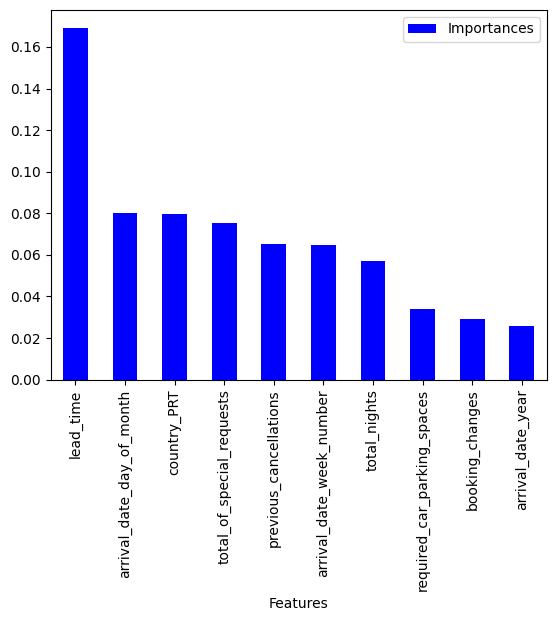

In [44]:
# Подбираем самые важные признаки
importances = model_forest.feature_importances_
# визуализация
final_df = pd.DataFrame({"Features": pd.DataFrame(features_test).columns, "Importances": importances})
final_df.set_index('Importances')

# Сортировка по по убыванию
final_df = final_df.sort_values('Importances', ascending=False)
print(final_df)

# Вывод гистограммы
final_df[:10].plot.bar( x='Features', color = 'blue')
final_df.info () 

**Вывод:**

Исходя из полученных данных "Ненадежный клиент"  бронирует номер более, чем за 30 дней до даты прибытия, является гражданином PRT ( свероятностью до 59%), и не имеет специальных отметок

## 6. Общий вывод

Внедрение модели дает прибыль не только при низком оттоке клиентов, но при отказе клиентов платить депозит:

Окупаемость наступает в течение месяца, т.к минимальная сумма прибыли составляет 1, 67 млн при бюджете на разработку в 400 тыс.

- Суммарная прибыль от продажи номеров до внедрения ML -  49055530.0
----------------------------------------------------------------
Оптимистичный прогноз:
   - суммарная прибыль после внедрения ML -  76715982.0
   - ожидаемый экономический эффект =        27660452.0
----------------------------------------------------------------
Пессимистичный прогноз:
   - суммарная прибыль после внедрения ML -   66753640.0
   - ожидаемый экономический эффект =        17698110.0


    Прогноз расчитан за не полный календарный год. Цифры выглядят слишком оптимистичными, поэтому в реальном бизнесе, лучше перепроверить предоставленные заказчиком данные и провести А/В тестирование перед внедрением модели.     
